In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
from pprint import pprint
import numpy as np
import descarteslabs as dl

from src.ReMasFrame import ReMasFrame

In [4]:
nasa_df = ReMasFrame()

# Choose an idx --> a landslide (or filter the geodataframe :D)
idx_test = 11031

# changes Point to Polygon
nasa_df_polygon = nasa_df.create_box(8000000)

# Returns products that we use as a dict
products = nasa_df.get_products()

/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [11]:
def get_scenes(product, buffer_size, res):
    # Returns start and end date of a 4 day interval
    start_date, end_date = nasa_df.date_interval(nasa_df.event_date[idx_test], delta=10)
    
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(buffer_size).envelope, 
        product['id'], 
        start_date=start_date, 
        end_date=end_date, 
        limit=10
    )
    
    new_ctx = ctx.assign(resolution=res)
    
    return scenes, new_ctx

## Obtención del producto

In [12]:
# Lista de categorias
products.keys()

dict_keys(['weather', 'soil_moist', 'elevation', 'population'])

In [13]:
# Elegir una categoria
cat = products["weather"]
# Mostrar productos
cat.keys()

dict_keys(['goes', 'gsod', 'chirps', 'cfs'])

In [14]:
# Elegir producto
prod = cat["gsod"]
prod

{'name': 'GSOD Daily Interpolation Weather Product',
 'id': 'daily-weather:gsod-interpolated:v0',
 'res': '10km',
 'bands': ['tavg', 'tmax', 'tmin', 'rh', 'prec'],
 'descrip': 'interpolated raster from 1980-01-01 for geographical area from -180 deg to 180 deg longitude, and from -60 to 60 deg latitude.'}

In [15]:
# Mostrar las bandas
prod["bands"]

['tavg', 'tmax', 'tmin', 'rh', 'prec']

In [28]:
# ELegir bandas
bands = prod["bands"][4]

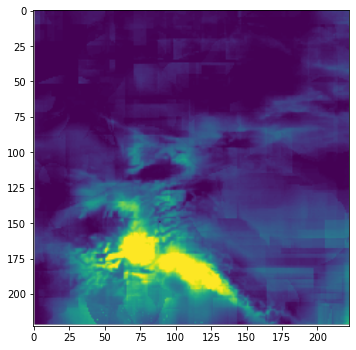

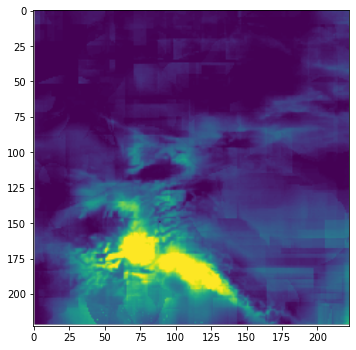

In [29]:
def get_composite(product, buffer_size, res, bands=None):
    
    scenes, new_ctx = get_scenes(product, buffer_size, res)
    
    bands = product["bands"] if bands is None else bands
    
    if not scenes:
        raise IndexError("El conjunto de escenas está vacía.")
        
    arr_stack = scenes.stack(bands, new_ctx)
    composite = np.ma.median(arr_stack, axis=0)
        
    
    return (scenes, new_ctx), composite

# Choose CHIRPS Daily Precip and correct res
(scenes, _), composite = get_composite(prod, buffer_size=10, res=0.09, bands=bands)

dl.scenes.save_image('precip_Kyrgyzstan_2017-04-29.png', composite, colormap='viridis', size=5)
dl.scenes.display(composite, colormap='viridis', size=5)

In [20]:
import numpy as np

# Choose CHIRPS Daily Precip and correct res
possible_reses = np.linspace(0.01, 1, 50)

for res in possible_reses:
    (scenes, ctx), composite = get_composite(prod, buffer_size=10, res=res)
    shape = scenes[-1].ndarray(prod['bands'], ctx).shape
    
    print(f"Shape using resolution {res:<20}: {shape}")

Shape using resolution 0.01                : (5, 2001, 2001)
Shape using resolution 0.030204081632653063: (5, 663, 663)
Shape using resolution 0.05040816326530612 : (5, 398, 397)
Shape using resolution 0.07061224489795918 : (5, 284, 285)
Shape using resolution 0.09081632653061224 : (5, 221, 222)
Shape using resolution 0.11102040816326529 : (5, 181, 181)
Shape using resolution 0.13122448979591836 : (5, 153, 154)
Shape using resolution 0.15142857142857144 : (5, 134, 133)
Shape using resolution 0.1716326530612245  : (5, 118, 118)
Shape using resolution 0.19183673469387755 : (5, 105, 106)
Shape using resolution 0.2120408163265306  : (5, 95, 95)
Shape using resolution 0.23224489795918368 : (5, 88, 87)
Shape using resolution 0.2524489795918367  : (5, 80, 80)
Shape using resolution 0.2726530612244898  : (5, 74, 75)
Shape using resolution 0.29285714285714287 : (5, 69, 70)
Shape using resolution 0.3130612244897959  : (5, 65, 65)
Shape using resolution 0.333265306122449   : (5, 61, 61)
Shape usi

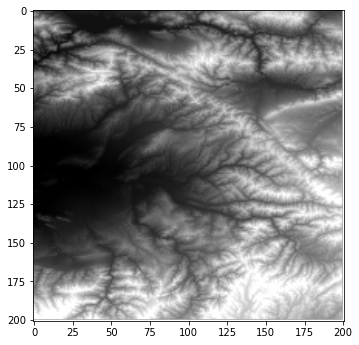

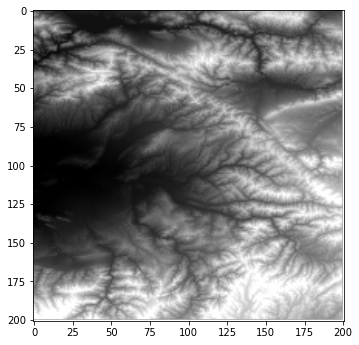

In [18]:
def get_dem():
    # Choose CHIRPS Daily Precip
    product = products['elevation']['aster']

    # Returns start and end date of a 4 day interval
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(1).envelope, 
        product['id'], 
        start_date='2013-10-01', 
        end_date='2013-12-01', 
        limit=10

    )

    new_ctx = ctx.assign(resolution=0.01)
    arr_stack = scenes.stack("height", new_ctx)

    composite = np.ma.median(arr_stack, axis=0)
    return scenes, composite

_, composite = get_dem()

dl.scenes.save_image('dem_Kyrgyzstan_2017-04-29.png', composite, size=5)
dl.scenes.display(composite, size=5)

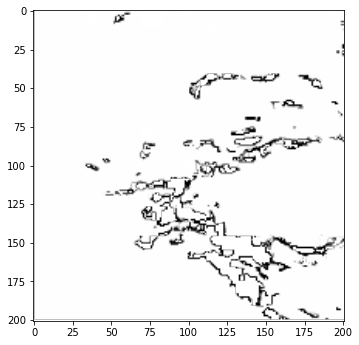

In [14]:
# Choose SMAP and correct res
scenes, ctx = get_scenes(products['soil_moist']['smap'], buffer_size=10, res=0.1)

arr_stack = scenes.stack("am_soil_moisture pm_soil_moisture", ctx)

composite = np.ma.median(arr_stack, axis=0)
dl.scenes.display(composite[0], size=5)

# dl.scenes.save_image('soil_moist_pm_Kyrgyzstan_2017-04-29.png', composite, size=5)
# dl.scenes.display(composite, size=5)